# Metric-Guided Prototyes

Welcome to the illustrative notebook of Metric-Guided Prototype Learning.

This a reimplementation of the code to obtain Figure 1. The modules to reproduce the full experiments are in the [github repository](https://github.com/VSainteuf/metric-guided-prototypes-pytorch).

The notebook is set to run on cpu by default but you can update the next cell to `cuda=1` to use a gpu. 
If you do not have an installed version of the torch_scatter package (not required for prototypes), make sure to switch on the `no_scatter` branch of the repository. 


In [1]:
cuda = 0

In [2]:
import sys
import torch
import torch.nn as nn
import torch.utils.data as data
import torchnet
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize,Compose, RandomAffine
from torchnet.meter import ClassErrorMeter, AverageValueMeter
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle as pkl
import json
import time
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from torch_prototypes.modules import prototypical_network, metric_embedding
from torch_prototypes.metrics import distortion, cost

rainbow = cm.get_cmap('rainbow', 12)
seq = [2,5,3,8,6,9,0,4,1,7]
cmap = [rainbow(i/10) for i in range(10)]
colorsh = dict(zip(seq,cmap))

MNIST_DIR = "./mnist-example/"

# Cost Matrix 

We now load the Cost matrix built between digits, either according to our perception or their numerical values:

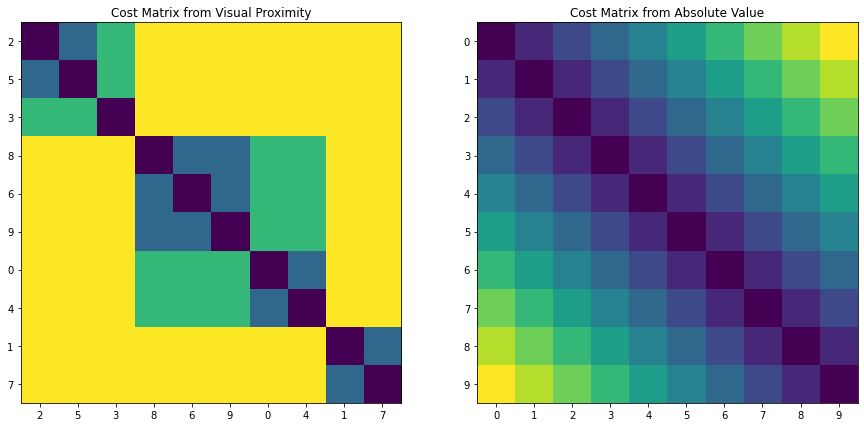

In [3]:
D_vis = torch.Tensor(pkl.load(open(MNIST_DIR + 'MNIST_D_visual.pkl','rb')))[:10,:][:,:10]
D_abs = torch.Tensor(pkl.load(open(MNIST_DIR + 'MNIST_D_absolute.pkl','rb'))[:10,:][:,:10])

seqlin = list(range(10))
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 2, 1, aspect='equal')
plt.title('Cost Matrix from Visual Proximity')
plt.xticks(seqlin, seq)
plt.yticks(seqlin, seq)
plt.imshow(D_vis[seq[::-1],:][:,seq[::-1]])
ax = fig.add_subplot(1, 2, 2, aspect='equal')
plt.title('Cost Matrix from Absolute Value')
plt.xticks(seqlin, seqlin)
plt.yticks(seqlin, seqlin)
plt.imshow(D_abs)
plt.show()

# Data

A wrapper of MNIST, with random rotations.

In [23]:
class MnistData(data.Dataset):
    def __init__(self, train=True,augment=False, root='mnist-example/'):
        super(MnistData, self).__init__()
        self.data = MNIST(root = root, train=train, download=True)        
        if augment:
            trsf = [RandomAffine(degrees=40, scale=(1.3,1.3)), ToTensor(), Normalize([0.13066062],[0.30810776])]
        else:
            trsf = [ToTensor(), Normalize([0.13066062],[0.30810776])]
        self.transforms = Compose(trsf)
        
    def __getitem__(self, item):
        x, y = self.data[item]
        return self.transforms(x), torch.Tensor([y]).long()
    
    def __len__(self):
        return len(self.data)

# Simple CNN model

3 layers of convolution, the previous-to-last layer is only of size 2. Not the best choice for performance, but it makes visualization much more straightforward.

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, classifier=True, cuda = 1):
        super(SimpleCNN, self).__init__()
        self.classifier = classifier
        self.conv1 = nn.Sequential(nn.Conv2d(1,16,3),nn.BatchNorm2d(16),nn.ReLU(),nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(16,16,3),nn.BatchNorm2d(16),nn.ReLU(),nn.MaxPool2d(2))
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,3),nn.BatchNorm2d(32),nn.ReLU())
        if classifier:
            self.fc = nn.Sequential(nn.Linear(32, 64),nn.Linear(64,2),nn.Linear(2,10))
        else:
            self.fc = nn.Sequential(nn.Linear(32, 64),nn.Linear(64,2))
        if cuda:
          self.cuda()
    def forward(self, x):
        out = self.conv3(self.conv2(self.conv1(x)))
        out = out.view(out.shape[0],out.shape[1], -1).max(-1)[0]
        out = self.fc(out)
        return out
    def get_embedding(self, x):
        out = self.conv3(self.conv2(self.conv1(x)))
        out = out.view(out.shape[0],out.shape[1], -1).max(-1)[0]
        if self.classifier:
          out = self.fc[0](out)
          out = self.fc[1](out)
        else:
          out = self.fc(out)
        return out

# Model Creation

This function create a simple CNN with or without metric-guidance, and a script to evaluet the performance of a model.

In [21]:
def create_model(mode='xe', D_metric=None, cuda=1):
  device = 'cuda' if cuda else 'cpu'
  D_metric = D_metric.cuda() if cuda and D_metric is not None else D_metric
  if mode == 'xe':
    model = SimpleCNN(classifier=True, cuda=cuda)
  elif 'proto' in mode:
    model = SimpleCNN(classifier=False, cuda=cuda) 
    model = prototypical_network.LearntPrototypes(model,n_prototypes=10 if D_metric is None else D_metric.shape[0],
                                 prototypes=None, embedding_dim=2, device=device)
  return model.cuda() if cuda else model

def evaluate(model, D_cost=None):
  cuda = next(model.parameters()).is_cuda
  #D_cost = D_cost.cuda() if cuda and D_cost is not None else D_cost

  dl_test = data.DataLoader(MnistData(train=False), batch_size=128, num_workers=4)

  ac = cost.AverageCost(D_cost)
  ER_meter = ClassErrorMeter(accuracy=False)
  AC_meter = AverageValueMeter()

  model.eval()
  with torch.no_grad():
    for x, y in dl_test:
      if cuda:
        x = x.cuda()
      y = y.squeeze()

      out = model(x)[:,:10]
      pred = out.detach().cpu()
        
      ER_meter.add(pred,y)
      if D_cost is not None:
        AC_meter.add(ac(pred.cpu(),y.cpu()))
    return ER_meter.value()[0], AC_meter.value()[0] if D_cost is not None else None  

# Visualization Functions

Visualize the embeddings of 2048 data points and the prototypes for prototype-based models.

In [67]:
def visualize(model, ax = None):
    if ax is None:
      fig, ax = plt.subplots(figsize=(8,8))

    model = model.cpu()
    if hasattr(model, 'prototypes'):
        protos = model.prototypes.detach().numpy()
        with_proto = True
    else:
        with_proto = False
    
    dt = MnistData(train=False,augment=False)
    dl = data.DataLoader(dt, batch_size=2048, num_workers=4, shuffle=True)

    b, y = dl.__iter__().__next__()
    y = y.squeeze()
    with torch.no_grad():
        if with_proto:
            out = model.model(b)
        else:
            out = model.get_embedding(b)
        
    out = out.detach().numpy()

    df = pd.DataFrame()
    df['x'] = out[:,0]
    df['y'] = out[:,1]

    df['label'] = list(map(str,y.numpy()))
    df['type'] = ['embedding' for _ in range(len(df.index))]
    df['size'] = [8 for _ in range(len(df.index))]
    
    if with_proto:
        prots = pd.DataFrame()
        prots['x'] = protos[:,0]
        prots['y'] = protos[:,1]
        prots['label'] = [str(i) for i in range(10)]
        prots['type'] = ['prototype' for _ in range(len(prots.index))]
        prots['size'] = [30 for _ in range(len(prots.index))]
        
    groups = df.groupby('label')

    ax.set_facecolor('k')

    for name, group in groups:
        ax.plot(group.x, group.y, marker='2', linestyle='', ms=5, label=name,c=colorsh[int(name)])
    #ax.legend()
    if with_proto:
        groups = prots.groupby('label')
        for name, group in groups:
            ax.plot(group.x, group.y, marker='h', linestyle='', ms=12, label=name,c=colorsh[int(name)], markeredgewidth=1.5, markeredgecolor='w')
    plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    plt.tick_params(axis='y',which='both',bottom=False,left=False,labelleft=False)

# Model loading

Loads the pre-trained models from the repository.

In [52]:
model_xe = create_model(mode='xe', cuda=cuda)
model_xe.load_state_dict(torch.load(MNIST_DIR + 'xe_model.pth.tar'))
model_free_proto = create_model(mode='proto', cuda=cuda)
model_free_proto.load_state_dict(torch.load(MNIST_DIR + 'free_proto_model.pth.tar'))
model_guided_proto_Dvis = create_model(mode='proto_disto', D_metric=D_vis, cuda=cuda)
model_guided_proto_Dvis.load_state_dict(torch.load(MNIST_DIR + 'pre-trained-D_visual/guided_proto_disto_model.pth.tar'))
model_fixed_proto_Dvis = create_model(mode='fix_proto_disto', D_metric=D_vis, cuda=cuda)
model_fixed_proto_Dvis.load_state_dict(torch.load(MNIST_DIR + 'pre-trained-D_visual/fix_proto_dito_model.pth.tar'))
model_guided_proto_Dabs = create_model(mode='proto_disto', D_metric=D_abs, cuda=cuda)
model_guided_proto_Dabs.load_state_dict(torch.load(MNIST_DIR + 'pre-trained-D_absolute/guided_proto_disto_model.pth.tar'))
model_fixed_proto_Dabs = create_model(mode='fix_proto_disto', D_metric=D_abs, cuda=cuda)
model_fixed_proto_Dabs.load_state_dict(torch.load(MNIST_DIR + 'pre-trained-D_absolute/fix_proto_dito_model.pth.tar'))

<All keys matched successfully>

#Visualization

Reproduce an extended version of our Figure 1.

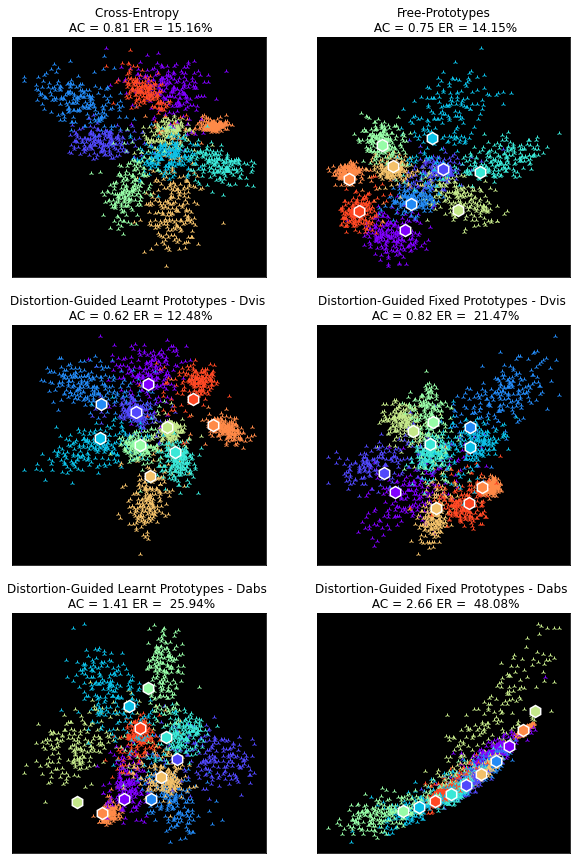

In [68]:
D = D_vis

fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(3, 2, 1)
ER, AC = evaluate(model_xe, D_cost=D)
visualize(model_xe, ax=ax) 
plt.title('Cross-Entropy \n AC = %1.2f ER = %2.2f%%' % (AC, ER))

ax = fig.add_subplot(3, 2, 2)
ER, AC = evaluate(model_free_proto, D_cost=D)
visualize(model_free_proto, ax=ax)
plt.title('Free-Prototypes\n AC = %1.2f ER = %2.2f%%' % (AC, ER))

ax = fig.add_subplot(3, 2, 3)
ER, AC = evaluate(model_guided_proto_Dvis, D_cost=D)
visualize(model_guided_proto_Dvis, ax=ax)
plt.title('Distortion-Guided Learnt Prototypes - Dvis \n AC = %1.2f ER = %2.2f%%' % (AC, ER))

ax = fig.add_subplot(3, 2, 4)
ER, AC = evaluate(model_fixed_proto_Dvis, D_cost=D)
visualize(model_fixed_proto_Dvis, ax=ax)
plt.title('Distortion-Guided Fixed Prototypes - Dvis \n AC = %1.2f ER =  %2.2f%%' % (AC, ER))

ax = fig.add_subplot(3, 2, 5)
ER, AC = evaluate(model_guided_proto_Dabs, D_cost=D)
visualize(model_guided_proto_Dabs, ax=ax)
plt.title('Distortion-Guided Learnt Prototypes - Dabs \n AC = %1.2f ER =  %2.2f%%' % (AC, ER))

ax = fig.add_subplot(3, 2, 6)
ER, AC = evaluate(model_fixed_proto_Dabs, D_cost=D)
visualize(model_fixed_proto_Dabs, ax=ax)
plt.title('Distortion-Guided Fixed Prototypes - Dabs \n AC = %1.2f ER =  %2.2f%%' % (AC, ER))

plt.show()

## Training script
A basic pytorch train loop which accomodates different models, with and without guidance. Can be used to retrain the models with different parameters.

In [50]:
def train_cnn_on_mnist(mode, l_metric=2, batch_size = 256, epochs = 30, milestones=[20,25], out_dir=None,D_metric=None,D_cost=D_vis, cuda=1):
    """ 
    mode = 'xe' or 'proto'
           'fixed' for fixed prototypes
           'rank' or 'disto' for different regularization
           'full' to add hidden prototypes
    l_metric = the regularization weights
    D_metric = the cost matrix used to define the finite metric (Dabs or Dvis or other)
    """
    D_metric = D_metric.cuda() if cuda and D_metric is not None else D_metric
    model = create_model(mode, D_metric, cuda)
    if 'proto' in mode and 'fix' in mode:
      metric = 'rank' if 'rank' in mode else 'disto'
      #train the prototypes separately
      model.prototypes.data = metric_embedding.embed_nomenclature(D_metric, embedding_dimension=2,loss=metric,lr=1)
      model.prototypes.requires_grad_(False)
    dl_train = data.DataLoader(MnistData(augment=True), batch_size=batch_size, num_workers=4, shuffle=True, drop_last=False)
    dl_test = data.DataLoader(MnistData(train=False), batch_size=batch_size, num_workers=4)

    if 'disto' in mode:
        delta = distortion.DistortionLoss(D_metric)
    if 'rank' in mode:
        delta = rank.RankLoss(D_metric, n_triplets=10)

    criterion = nn.CrossEntropyLoss()
    ac = cost.AverageCost(D_cost)

    opt = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=0e-4)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones,gamma=0.1)
    log = {}
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()

        model.train()
        t0 = time.time()
        for x, y in dl_train:
            if cuda:
                x, y = x.cuda(), y.cuda()
            y = y.squeeze()
            out = model(x)
            opt.zero_grad()
            if 'full' in mode:
                out = out[:,:10]
            loss = criterion(out, y)
            if 'disto' in mode or 'rank' in mode:
                if 'fix' not in mode:
                    loss = loss +  l_metric * delta(model.prototypes)
           
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
            AC_meter.add(ac(pred.cpu(),y.cpu()))
            
        scheduler.step()
        t1 = time.time()
        log[epoch] = {'train_ER':ER_meter.value()[0], 'train_AC':AC_meter.value()[0], 'train_time':t1-t0}
        
        print('Train ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        AC_meter = AverageValueMeter()
        t0 = time.time()
        for x, y in dl_test:
            if cuda:
                x = x.cuda()
            y = y.squeeze()
            with torch.no_grad():
                out = model(x)
            if 'full' in mode:
                out = out[:,:10]
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
            AC_meter.add(ac(pred.cpu(),y))
        t1 = time.time()
        print('Test ER {:.2f}, AC {:.3f}, time {:.1f}s'.format(ER_meter.value()[0], AC_meter.value()[0], t1-t0))
        log[epoch].update({'test_ER':ER_meter.value()[0], 'test_AC':AC_meter.value()[0], 'test_time':t1-t0})

    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(out_dir, '{}_model.pth.tar'.format(mode)))
        with open(os.path.join(out_dir,'log.json'),'w') as file:
            file.write(json.dumps(log, indent=4))
            
    return model


# Training from scracth

This is will retrain the models from scratch. Select the models you want to be visualized. Each model should take about 3-4 min to train.

Remove the models that you are not interested in, and select D = Dvis or Dabs or build your own cost matrix. 

In [18]:
models_to_train = ['xe', 'free_proto', 'proto_disto', 'fixed_proto']
D = D_vis #D_abs
cuda = 0

In [ ]:
model_xe =  train_cnn_on_mnist(mode='xe', cuda=cuda) if 'xe' in models_to_train else None
model_proto_free =  train_cnn_on_mnist(mode='proto', cuda=cuda) if 'free_proto' in models_to_train else None
model_proto_disto =  train_cnn_on_mnist(mode='proto_disto', D_metric=D, l_metric=.5, cuda=cuda) if 'proto_disto' in models_to_train else None
model_proto_fix =  train_cnn_on_mnist(mode='fix_proto_disto', D_metric=D, l_metric=1, cuda=cuda) if 'fixed_proto' in  models_to_train else None

# Visualization

This will create a simple figure to show the results of the re-trained model.

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 2, 1)
if model_xe is not None:
  visualize(model_xe, ax)
  ER, AC = evaluate(model_xe, D_cost=D_vis)
  plt.title('Cross-Entropy - Dvis \n AC = %1.2f ER = %2.2f%%' % (AC, ER))
ax = fig.add_subplot(2, 2, 2)
if model_proto_free is not None:
  ER, AC = evaluate(model_proto_free, D_cost=D_vis)
  visualize(model_proto_free, ax=ax)
  plt.title('Free-Prototypes\n AC = %1.2f ER = %2.2f%%' % (AC, ER))
ax = fig.add_subplot(2, 2, 3)
if model_proto_disto is not None:
  ER, AC = evaluate(model_proto_disto, D_cost=D_vis)
  visualize(model_proto_disto, ax=ax)
  plt.title('Distortion-Guided Learnt Prototypes - Dvis \n AC = %1.2f ER = %2.2f%%' % (AC, ER))
ax = fig.add_subplot(2, 2, 4)
if model_proto_fix is not None:
  ER, AC = evaluate(model_proto_fix, D_cost=D_vis)
  visualize(model_proto_fix, ax=ax)
  plt.title('Distortion-Guided Fixed Prototypes - Dvis \n AC = %1.2f ER =  %2.2f%%' % (AC, ER))
plt.show()